In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
#Data preparation
#Splitting data into train, valid and test dirs
#Data 25,000 images so we are going to split the data as 
#=> 1000 images -> Training data, 200 -> Validation set, 100 -> Test set

os.chdir('data/dogs-vs-cats')
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')

    for i in random.sample(glob.glob('cat*'), 500):
        shutil.move(i, 'train/cat')      
    for i in random.sample(glob.glob('dog*'), 500):
        shutil.move(i, 'train/dog')
    for i in random.sample(glob.glob('cat*'), 100):
        shutil.move(i, 'valid/cat')        
    for i in random.sample(glob.glob('dog*'), 100):
        shutil.move(i, 'valid/dog')
    for i in random.sample(glob.glob('cat*'), 50):
        shutil.move(i, 'test/cat')      
    for i in random.sample(glob.glob('dog*'), 50):
        shutil.move(i, 'test/dog')

os.chdir('../../')

In [3]:
train_path = 'data/dogs-vs-cats/train'
valid_path = 'data/dogs-vs-cats/valid'
test_path = 'data/dogs-vs-cats/test'

In [4]:
#Data preprocessing using very popular model called vgg16
#target_size = (224, 224) sets the image size to height and width to 224, 224
#We are setting shuffle = False for test_batches, so that whenever in future.. 
#we are going to predict and use confusion matrix for that we want unshuffled 
#labels to compare with and therefore gauge the model

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [5]:
#We are verifying that above cell o/p the below written statements
#assert is used when we are debugging the code, 
#so to verify that our conditions are true otherwise AssertionErr de dega code

assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [6]:
#We have 3 batches(train, valid, test), here we are grabbing train_batch with batch_size = 10
imgs, labels = next(train_batches)

In [7]:
#Fxn from tf documentation to plot images...

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

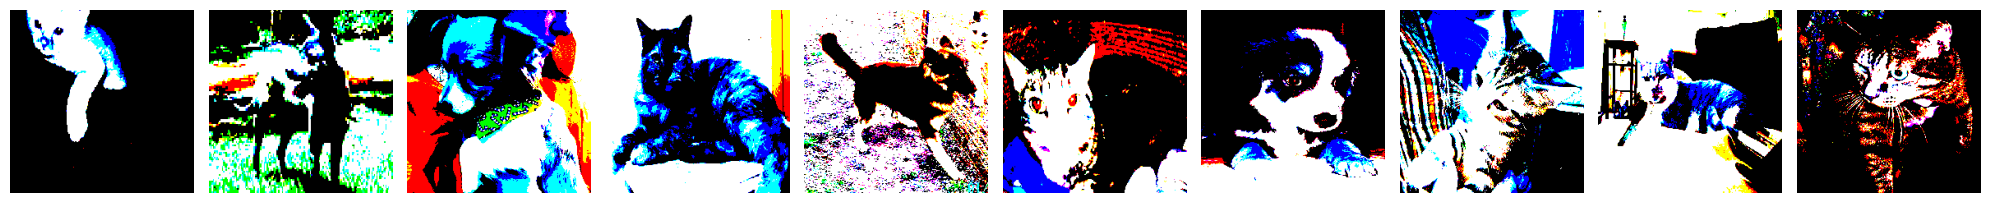

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [8]:
#Color data distorted due to the preprocessing fxn that we called, vgg16 model
plotImages(imgs)
print(labels)

In [9]:
#Building and training a CNN
#padding = 'same' means that we are setting padding to zero so that outside the input image so that
#the image aren't reduced after the completion operation
#Conv2D is 1st Hidden layer, input_shape = (224, 224, 3) => 3 -> RGB format
#MaxPooling cuts our image dimen into half

model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 2)                 4

In [11]:
#We can also use binary_crossentropy loss for 2 classes
#set o/p layer node to 1 and use sigmoid fxn

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [12]:
model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
    verbose=2
)

Epoch 1/10
100/100 - 30s - loss: 23.3122 - accuracy: 0.5670 - val_loss: 4.0274 - val_accuracy: 0.6300 - 30s/epoch - 301ms/step
Epoch 2/10
100/100 - 33s - loss: 1.5212 - accuracy: 0.7820 - val_loss: 2.9778 - val_accuracy: 0.6400 - 33s/epoch - 331ms/step
Epoch 3/10
100/100 - 29s - loss: 0.4089 - accuracy: 0.9040 - val_loss: 3.1919 - val_accuracy: 0.6400 - 29s/epoch - 294ms/step
Epoch 4/10
100/100 - 28s - loss: 0.4433 - accuracy: 0.8970 - val_loss: 2.9719 - val_accuracy: 0.6400 - 28s/epoch - 283ms/step
Epoch 5/10
100/100 - 28s - loss: 0.3284 - accuracy: 0.9310 - val_loss: 2.6133 - val_accuracy: 0.6800 - 28s/epoch - 279ms/step
Epoch 6/10
100/100 - 40s - loss: 0.0380 - accuracy: 0.9910 - val_loss: 2.7590 - val_accuracy: 0.6500 - 40s/epoch - 403ms/step
Epoch 7/10
100/100 - 53s - loss: 0.0068 - accuracy: 0.9980 - val_loss: 2.5652 - val_accuracy: 0.6400 - 53s/epoch - 529ms/step
Epoch 8/10
100/100 - 52s - loss: 9.4968e-04 - accuracy: 1.0000 - val_loss: 2.5516 - val_accuracy: 0.6450 - 52s/epoch 

In [13]:
#Predicting using CNNs
test_imgs, test_labels = next(test_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

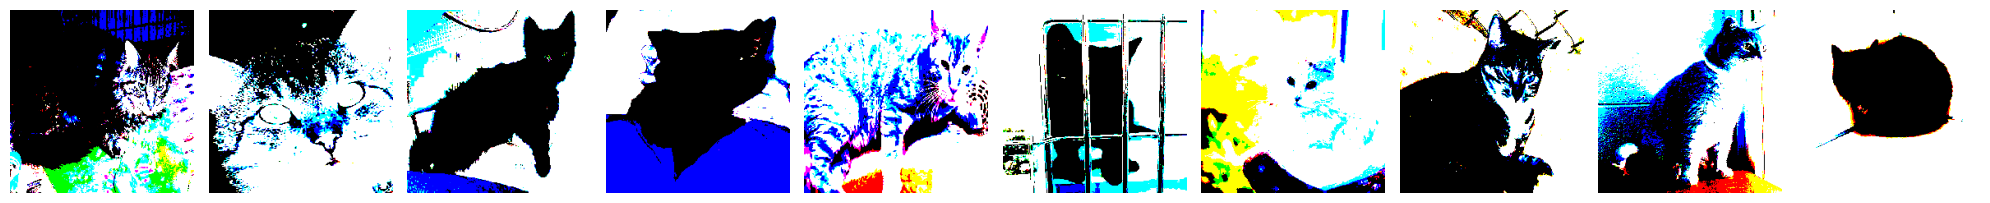

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [14]:
plotImages(test_imgs)
print(test_labels)

In [15]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [16]:
np.round(predictions)

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [17]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[27 23]
 [14 36]]


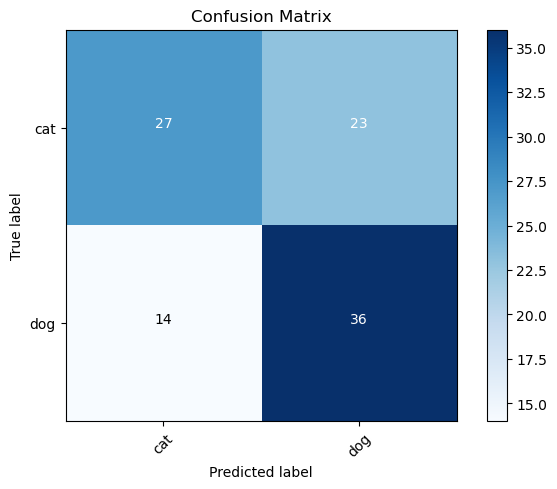

In [20]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [21]:
#Taking vgg16 model and converting it to sequential model and then training it and then predicting using the seq+vgg16 model
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [22]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [23]:
type(vgg16_model)

keras.engine.functional.Functional

In [24]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [25]:
#Freezing the layers so that overtrain na hojaaye
for layer in model.layers:
    layer.trainable = False

In [26]:
#since we are predicting for 2 classes, apan ne model uthaya, 
#sequential mein convert kiya aur phir o/p layer hatayi aur 
#apan ko jitni classes predict karni thi apan ne utne hee node rkhi = 2...
model.add(Dense(units=2, activation='softmax'))

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [28]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=5,
          verbose=2
)

Epoch 1/5
100/100 - 258s - loss: 0.2904 - accuracy: 0.8690 - val_loss: 0.1122 - val_accuracy: 0.9500 - 258s/epoch - 3s/step
Epoch 2/5
100/100 - 274s - loss: 0.0806 - accuracy: 0.9700 - val_loss: 0.0897 - val_accuracy: 0.9600 - 274s/epoch - 3s/step
Epoch 3/5
100/100 - 262s - loss: 0.0517 - accuracy: 0.9830 - val_loss: 0.0630 - val_accuracy: 0.9750 - 262s/epoch - 3s/step
Epoch 4/5
100/100 - 190s - loss: 0.0370 - accuracy: 0.9930 - val_loss: 0.0621 - val_accuracy: 0.9700 - 190s/epoch - 2s/step
Epoch 5/5
100/100 - 211s - loss: 0.0273 - accuracy: 0.9940 - val_loss: 0.0547 - val_accuracy: 0.9800 - 211s/epoch - 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

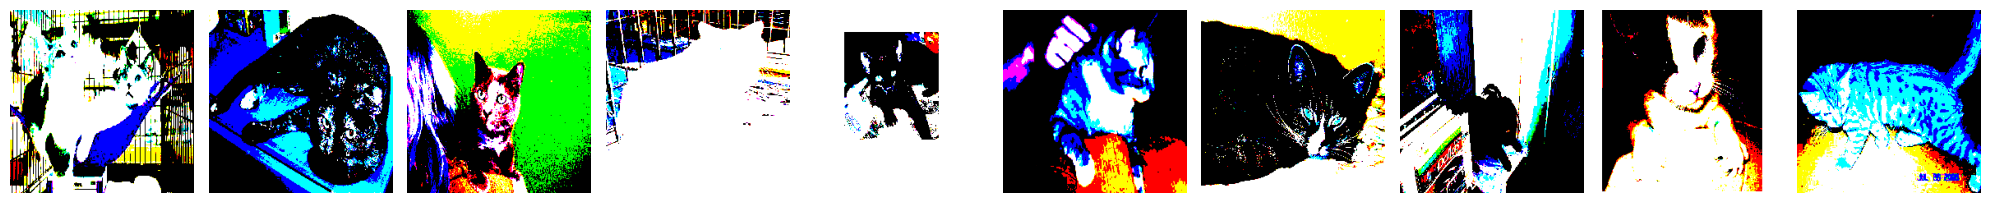

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [30]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [31]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

Confusion matrix, without normalization
[[48  2]
 [ 1 49]]


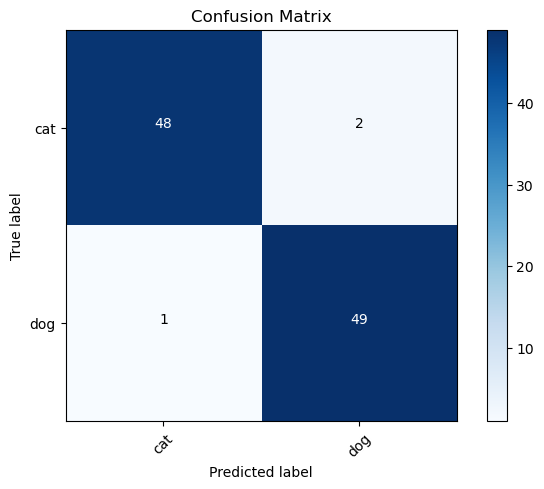

In [32]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')